In [2]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

In [3]:
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"
CONTENT_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/reference/"

NOISY500 = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy500"
NOISY20 = "/home/yifan/dataset/noisy/pairflip/cifar10/20"
sys.path.append(REF_PATH)
sys.path.append(CONTENT_PATH)

from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


from config import config

ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
# REFERENCE
noisy_data_provider = NormalDataProvider(NOISY500,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )

clean_data_provider = NormalDataProvider(CLEAN_PATH,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1  )
clean_data = clean_data_provider.train_representation(200).squeeze()

ref_train_data = ref_provider.train_representation(200).squeeze()

# EPOCH 200
train_data = data_provider.train_representation(200).squeeze()
# EPOCH 199
# prev_train_data = data_provider.train_representation(199).squeeze()

noisy_data = noisy_data_provider.train_representation(200).squeeze()

Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [4]:

# @attr.s(auto_attribs=True)
class TheTrainer:
    """Trains the word-embeddings data

    Args:
     x_train: the training input
     y_train: the training labels
     training_steps: number of times to run the training loop
     learning_rate: multiplier for the gradient (alpha)
     seed: random-seed for numpy
     loss_every: if verbose, how often to show loss during fitting
     verbose: whether to emit messages
    """
    x_train: np.ndarray
    y_train: np.ndarray
    training_steps: int=400
    learning_rate: float=0.8
    seed: int=129
    loss_every: int=25
    verbose: bool=True

In [20]:
from torch import nn
import json

import scipy
import numpy as np
from sklearn.cross_decomposition import CCA
import torch.nn.functional as F
from torch.autograd import Variable

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

# Step1: Computing the loss 
def compute_loss(X,Y,R):
    '''
     The loss function will be the squared Frobenoius norm of the difference between the matrix and its approximation, divided by the number of training examples m
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
        L: a matrix of dimension (m,n) -the value of the loss function for given X, Y and R
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # Xnew = np.dot(X, R)


    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss


# Step2: Computing the loss 
def compute_gradient(X, Y, R):
    lr = 0.003
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    Xnew = torch.mm(X, R)


    rows, columns = X.shape




    loss = (( torch.mm(X, R) - Y)**2).sum()
    loss.backward()
    R.data = R.data - lr * R.grad.data
    print("loss",loss)

    return gradient,loss


def regression_loss(x, y):
    x = F.normalize(x, dim=1)
    y = F.normalize(y, dim=1)
    return 2 - 2 * (x * y).sum(dim=-1)
def update(X,Y, X_provider, Y_provider, R):
    before_pred = Y_provider.get_pred(200, Y_provider.train_representation(200))
    norm_before_pred = F.normalize(torch.Tensor(before_pred), dim=1)

    # y = F.normalize(y, dim=1)
    after_pred  = Y_provider.get_pred(200, np.dot(X_provider.train_representation(200),R.detach().numpy()))
    norm_after_pred = F.normalize(torch.Tensor(after_pred), dim=1)

    R = F.normalize(R, dim=1)

    loss = regression_loss(torch.Tensor(before_pred), torch.Tensor(after_pred))
    # loss2 = F.mse_loss(torch.tensor(before_pred),torch.tensor(after_pred))
    loss.requires_grad_(True)
    # print("loss222",loss2)
    # loss = 2 - 2 * (norm_after_pred  *  ).sum(dim=-1)
    return loss.mean()



# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,X_provider,Y_provider,
                      train_steps: int=3000,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    # R = np.random.rand(X.shape[1], X.shape[1])
    R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

    m = len(X)

    rows, columns = X.shape


    for i in range(train_steps):
        # compute_gradient(X,Y,R)
        X = torch.Tensor(X)
        Y = torch.Tensor(Y)
        Xnew = torch.mm(X, R)
        loss = ((( X.matmul(R) - Y)**2).sum())/m
        
        
        # before_pred = F.normalize(torch.Tensor(X_provider.get_pred(200, X_provider.train_representation(200))), dim=1)
   
        lossFn = update(X,Y,X_provider,Y_provider,R)

  

        # lossFn.backward()

        
        if i % 10 == 0:
            lossv = compute_loss(X.detach().numpy(),Y.detach().numpy(),R.detach().numpy())
            print("iteration:",i,'losss:',lossv,"another",lossFn)



        loss.backward()
        lossFn.backward()
        # lossCON = loss + lossFn
        # lossCON.backward()
        # grad = (np.dot(X.detach().numpy().T, np.dot(X.detach().numpy(), R.detach().numpy()) - Y.detach().numpy()) * 2)/rows

        R.data = R.data - learning_rate * R.grad.data

        R.grad.data.zero_()
        



    return R

np.random.seed(129)
m = 10
n = 5
X = clean_data
Y = ref_train_data
R = align_embeddings(X, Y, noisy_data_provider, clean_data_provider)
print(R)


100%|██████████| 250/250 [00:00<00:00, 7120.04it/s]


iteration: 0 losss: 479794246451.2 another tensor(4.7803e-09, grad_fn=<MeanBackward0>)


AttributeError: 'NoneType' object has no attribute 'data'

In [6]:

b = R.clone().detach().cpu().numpy()
print(b)


[[-0.03081775 -0.00692639 -0.00990473 ... -0.02322331 -0.01315602
   0.0025262 ]
 [-0.01897927 -0.01347626 -0.02000007 ... -0.02298753 -0.01887964
  -0.00460973]
 [ 0.04369356  0.03329757  0.03579324 ...  0.03649963  0.03591968
   0.03065583]
 ...
 [-0.06434827 -0.04459582 -0.05335038 ... -0.04768343 -0.05058205
  -0.04755687]
 [-0.00308336 -0.00706821  0.00711471 ... -0.00278356 -0.00432571
  -0.0038786 ]
 [-0.06806876 -0.07867278 -0.07420958 ... -0.08872132 -0.07132445
  -0.07975945]]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9142.14it/s]


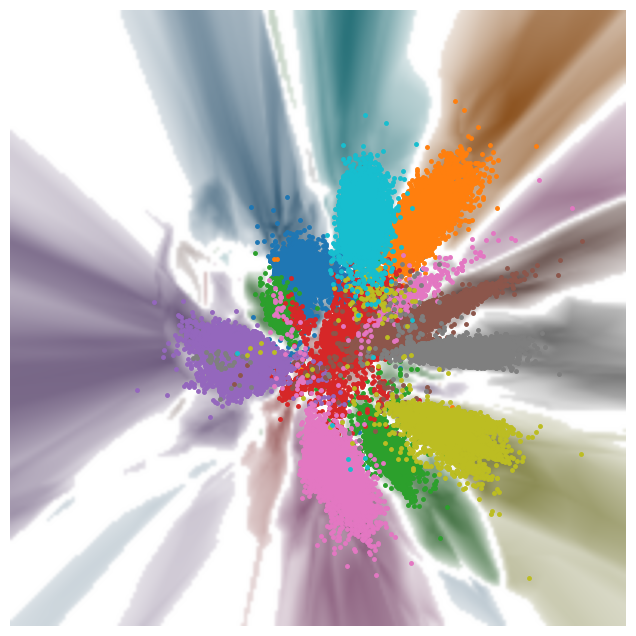

In [12]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider,clean_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8973.46it/s]


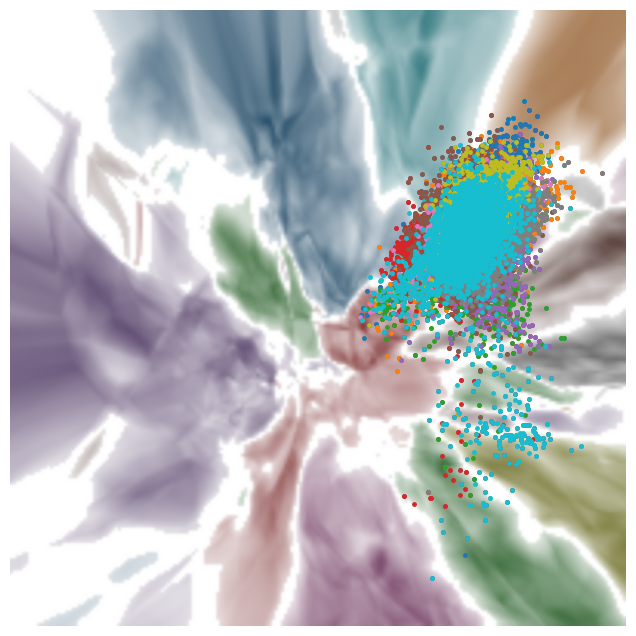

In [13]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider,noisy_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8712.50it/s]


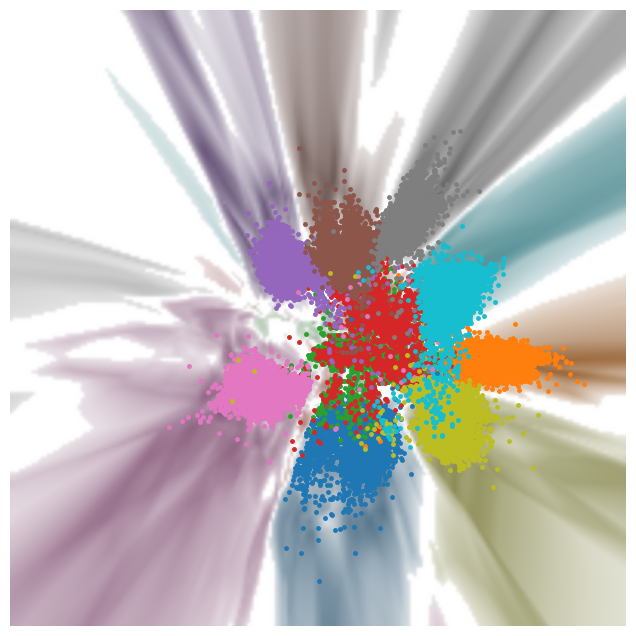

In [15]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=NOISY500, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy_data_provider,noisy_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 472.67it/s]


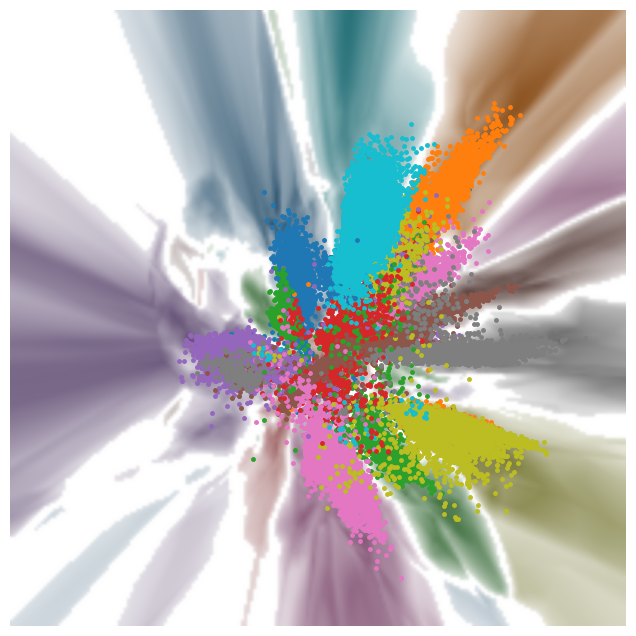

In [7]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider,np.dot(noisy_data,b), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))